In [10]:
import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import random
import implicit

from sklearn.preprocessing import MinMaxScaler
from scipy.sparse.linalg import spsolve
from tools import *
import matplotlib.pyplot as plt

In [2]:
# Load the sparse matrix of playlists by songs from KNeighborsModel
raw_data = pd.read_csv('data/sparse_df.csv')
obscured_df = pd.DataFrame.copy(raw_data)

# Obscure each playlist in set by removing half the songs
obscureds = [] #indexes of obscured lists
n_obscured = []

#We need to add in the user's seed playlist to this dataset.
for i, playlist in raw_data.iterrows():
    obscured_list = remove_songs(list(playlist), 0.5)
    obscured_df.iloc[i] = obscured_list
    obscureds.append(raw_data.shape[0] + i)
    n_obscured.append(int(sum(obscured_list)))
    
# This model requires that the playlists for which it recommends new songs for are a part of the fitting matrix
data = pd.concat([raw_data, obscured_df])

In [3]:
# The implicit library expects data as a song-play matrix so we
# create two matricies, one for fitting the model (song_play) 
# and one for recommendations (play_song)
sparse_song_play = sparse.csr_matrix(data)
sparse_play_song = sparse.csr_matrix(data.transpose())

In [5]:
# Initialize the als model and fit it using the sparse song-playlist matrix
model = implicit.als.AlternatingLeastSquares(factors=15, regularization=0.1, iterations=30)

# regularization and alpha_val based on literature

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 40 
data_conf = (sparse_song_play * alpha_val).astype('double')

#Fit the model
model.fit(data_conf)

In [7]:
# Vary number of factors
mean_rprec = []
mean_ndcgs = []
factors = np.arange(1, 51)

for fac in factors:
    # Initialize the als model and fit it using the sparse song-playlist matrix
    model = implicit.als.AlternatingLeastSquares(factors=fac, regularization=0.1, iterations=30)

    # regularization and alpha_val based on literature

    # Calculate the confidence by multiplying it by our alpha value.
    alpha_val = 40 
    data_conf = (sparse_song_play * alpha_val).astype('double')

    #Fit the model
    model.fit(data_conf)
    
    pred_songs_bool = []

    for index, seed in enumerate(obscureds):
        recommended = model.recommend(seed, sparse_play_song, N=n_obscured[index])
        pred_songs = []
        for item in recommended:
            song_idx, score = item
            pred_songs.append(data.columns[song_idx])
        pred_songs_bool.append(get_song_bool_list(pred_songs, data))

    # Score the model's performance in the test set. 
    r2 = []
    ndcgs = []
    for i, pred in enumerate(pred_songs_bool):
        pred_idx = [idx for idx, p in enumerate(pred) if p == 1]
        right = np.array(raw_data.iloc[i]) - np.array(data.iloc[i+raw_data.shape[0]])
        right_idx = [idx for idx, r in enumerate(right) if r == 1]
        r2.append(sum([1 for pidx in pred_idx if pidx in right_idx])/len(pred_idx))
        r = [1 if idx in pred_idx else 0 for idx in right_idx]
        ndcgs.append(ndcg_at_k(r, len(r)))
        
    mean_rprec.append(np.mean(r2))
    mean_ndcgs.append(np.mean(ndcgs))

In [8]:
best_idx = np.argmax(np.array(mean_rprec) + np.array(mean_ndcgs))
print("Number of factors that maximizes factors: {}".format(factors[best_idx]))
print("NDCGS for that model: {}".format(mean_ndcgs[best_idx]))
print("R2 precision for that model: {}".format(mean_rprec[best_idx]))

Number of factors that maximizes factors: 7
NDCGS for that model: 0.15654781307272608
R2 precision for that model: 0.0043448114702824975


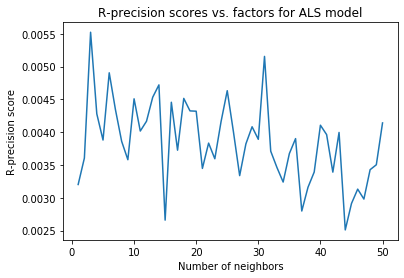

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(factors, mean_rprec)
plt.title("R-precision scores vs. factors for ALS model")
plt.xlabel("Number of neighbors")
plt.ylabel("R-precision score")
plt.savefig("data/ALS_R.png")

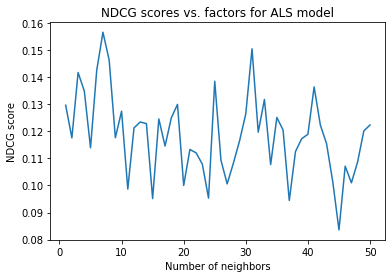

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(factors, mean_ndcgs)
plt.title("NDCG scores vs. factors for ALS model")
plt.xlabel("Number of neighbors")
plt.ylabel("NDCG score")
plt.savefig("data/ALS_NDCG.png")